In [1]:
#import needed libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tensorflow import keras
from keras.models import load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.preprocessing import image
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix

import os

In [2]:
pip install split-folders --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
import splitfolders
splitfolders.ratio("/kaggle/input/flowers-recognition/flowers",output="Tr-Te-Val",ratio=(0.8,0.1,0.1))

Copying files: 4317 files [00:25, 169.56 files/s]


In [4]:
train_gen = Imgen(preprocessing_function=keras.applications.densenet.preprocess_input,
                 zoom_range=0.2,
                  shear_range=0.2,
                  vertical_flip=True,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                 )

val_gen = Imgen(preprocessing_function=keras.applications.densenet.preprocess_input,
                 zoom_range=0.2,
                  shear_range=0.2,
                  vertical_flip=True,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                 )

test_gen = Imgen(preprocessing_function=keras.applications.densenet.preprocess_input
                 )

In [5]:
train_ds = train_gen.flow_from_directory("./Tr-Te-Val/train",
                                       target_size=(331,331),
                                        seed = 123,
                                        batch_size=32
                                       )

val_ds = val_gen.flow_from_directory("./Tr-Te-Val/val",
                                       target_size=(331,331),
                                        seed = 123,
                                        batch_size=32)

test_ds = test_gen.flow_from_directory("./Tr-Te-Val/test",
                                       target_size=(331,331),
                                        seed = 123,
                                        batch_size=32,
                                      shuffle=False
                                      )

Found 3452 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


In [6]:
a = train_ds.class_indices
classes = list(a.keys())
print(classes)
b = test_ds.class_indices
classes = list(b.keys())
print(classes)
c = val_ds.class_indices
classes = list(c.keys())
print(classes)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [7]:
#one batch
X,Y = next(train_ds)

In [8]:
#plot function
def plot_images(img,labels):
    plt.figure(figsize=(15,10))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(img[i])
        plt.title(classes[np.argmax(labels[i])])
        plt.axis('off')

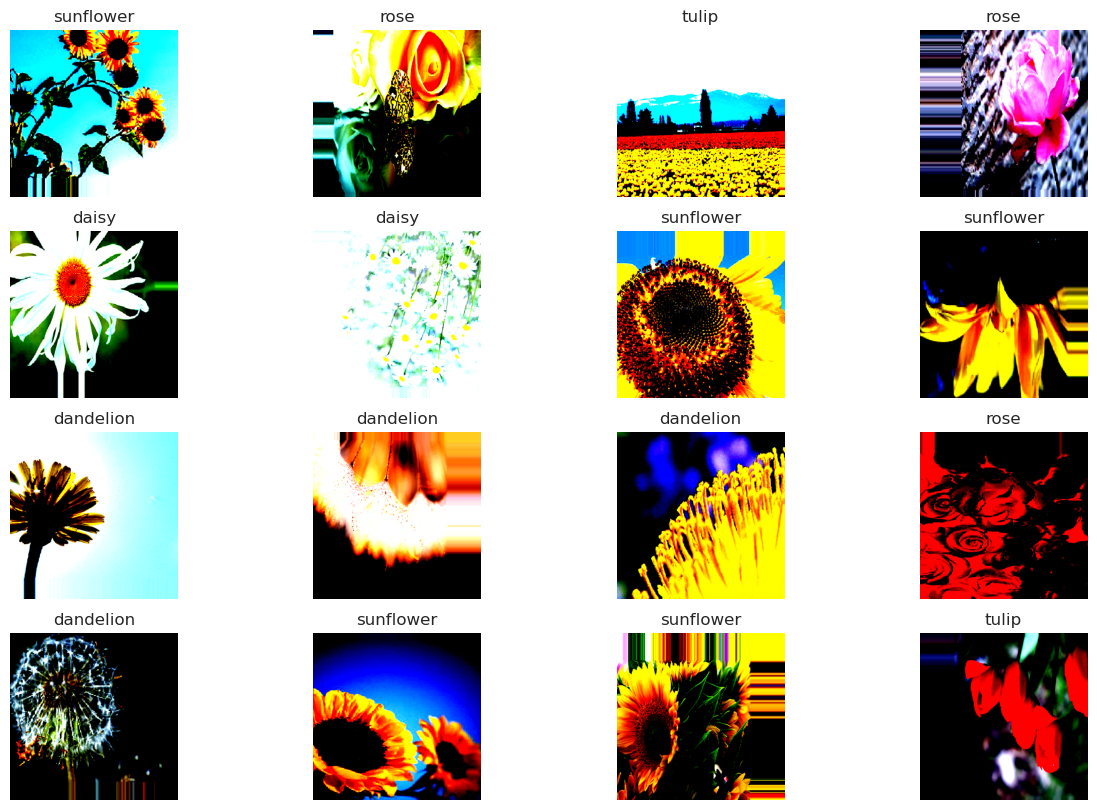

In [9]:
plot_images(X,Y)

In [10]:
from keras.applications.densenet import DenseNet201

In [11]:
base_model = DenseNet201(include_top=False,
                  input_shape=(331,331,3),
                   weights = 'imagenet',
                    pooling='avg'
                  )
base_model.trainable = False

74836368/74836368 [==============================] - 0s 0us/step


In [12]:
inputs = base_model.input
l1 = Dense(128,activation='relu')(base_model.output)
outputs = Dense(5,activation='softmax')(l1)
model = keras.Model(inputs=inputs,outputs=outputs)

In [13]:
#compile 
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
#callbacks
my_calls = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),
            keras.callbacks.ModelCheckpoint("model_dense.h5",verbose=1,save_best_only=True)]

In [15]:
history = model.fit(train_ds,epochs=18,validation_data=val_ds,callbacks=my_calls)

Epoch 1/18
108/108 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.7984
Epoch 1: val_loss improved from inf to 0.36436, saving model to model_dense.h5
108/108 [==============================] - 131s 1s/step - loss: 0.5603 - accuracy: 0.7984 - val_loss: 0.3644 - val_accuracy: 0.8721
Epoch 2/18
108/108 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8879
Epoch 2: val_loss improved from 0.36436 to 0.32974, saving model to model_dense.h5
108/108 [==============================] - 106s 977ms/step - loss: 0.3024 - accuracy: 0.8879 - val_loss: 0.3297 - val_accuracy: 0.8698
Epoch 3/18
108/108 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.9035
Epoch 3: val_loss improved from 0.32974 to 0.30454, saving model to model_dense.h5
108/108 [==============================] - 106s 980ms/step - loss: 0.2629 - accuracy: 0.9035 - val_loss: 0.3045 - val_accuracy: 0.8884
Epoch 4/18
108/108 [==============================] - ETA: 0s - l

In [16]:
model = load_model("/kaggle/working/model_dense.h5")

In [17]:
#test
model.evaluate(test_ds)

14/14 [==============================] - 8s 372ms/step - loss: 0.3236 - accuracy: 0.9011


[0.3235628008842468, 0.9011494517326355]

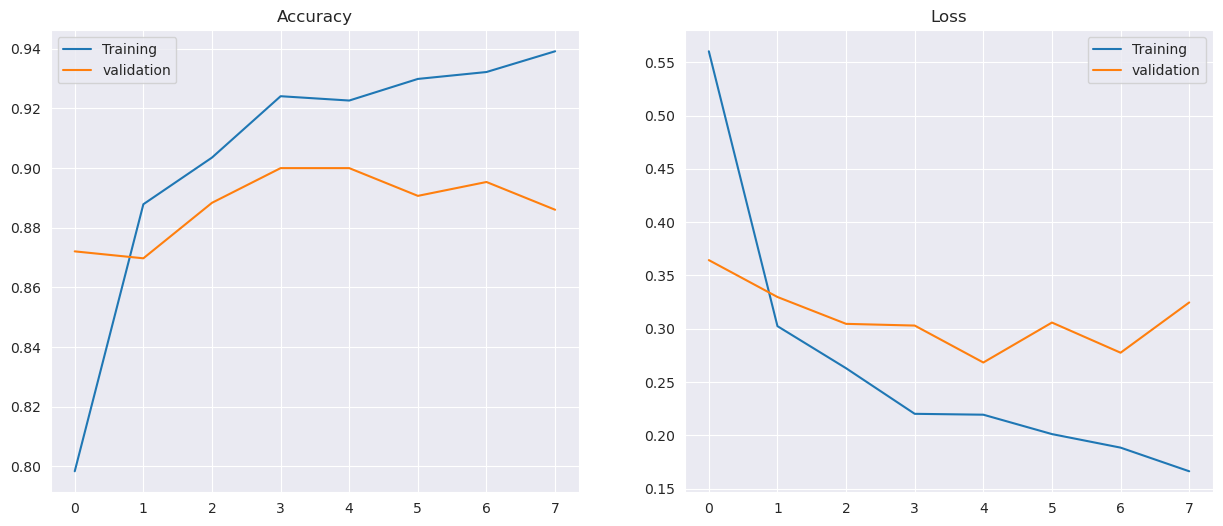

In [18]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['accuracy'],label = 'Training')
plt.plot(history.epoch,history.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['loss'],label = 'Training')
plt.plot(history.epoch,history.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

In [19]:
preds = model.predict(test_ds,verbose=1)

14/14 [==============================] - 6s 233ms/step


In [20]:
pred = [np.argmax(i) for i in preds]
pred[:5]

[1, 0, 0, 0, 0]

In [21]:
actual = test_ds.classes

In [22]:
print(classification_report(pred,actual))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        75
           1       0.97      0.91      0.94       113
           2       0.99      0.77      0.87       101
           3       0.96      0.95      0.95        75
           4       0.71      0.99      0.82        71

    accuracy                           0.90       435
   macro avg       0.91      0.91      0.90       435
weighted avg       0.92      0.90      0.90       435



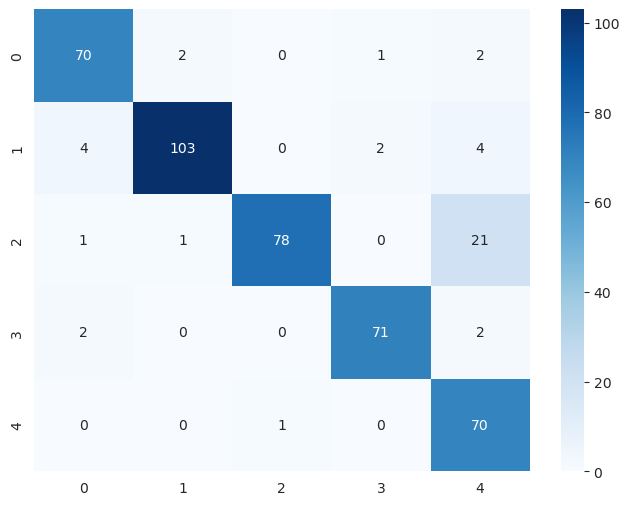

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred,actual),annot = True, fmt = 'd', cmap = 'Blues');

**Fine Tuning**

In [24]:
base_model.trainable = True
optimizer = keras.optimizers.Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
my_calls = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),
            keras.callbacks.ModelCheckpoint("model_dense_tune.h5",verbose=1,save_best_only=True)]

In [26]:
history1 = model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=my_calls)

Epoch 1/10
108/108 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.9258
Epoch 1: val_loss improved from inf to 0.29771, saving model to model_dense_tune.h5
108/108 [==============================] - 120s 1s/step - loss: 0.2166 - accuracy: 0.9258 - val_loss: 0.2977 - val_accuracy: 0.9000
Epoch 2/10
108/108 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9267
Epoch 2: val_loss did not improve from 0.29771
108/108 [==============================] - 104s 965ms/step - loss: 0.1896 - accuracy: 0.9267 - val_loss: 0.3188 - val_accuracy: 0.8860
Epoch 3/10
108/108 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9458
Epoch 3: val_loss did not improve from 0.29771
108/108 [==============================] - 104s 967ms/step - loss: 0.1555 - accuracy: 0.9458 - val_loss: 0.3056 - val_accuracy: 0.9070
Epoch 4/10
108/108 [==============================] - ETA: 0s - loss: 0.1601 - accuracy: 0.9392
Epoch 4: val_loss improved from 0.29

In [27]:
model1 = load_model("/kaggle/working/model_dense_tune.h5")

In [28]:
model1.evaluate(test_ds)

14/14 [==============================] - 6s 234ms/step - loss: 0.2606 - accuracy: 0.9218


[0.2605762779712677, 0.9218390583992004]

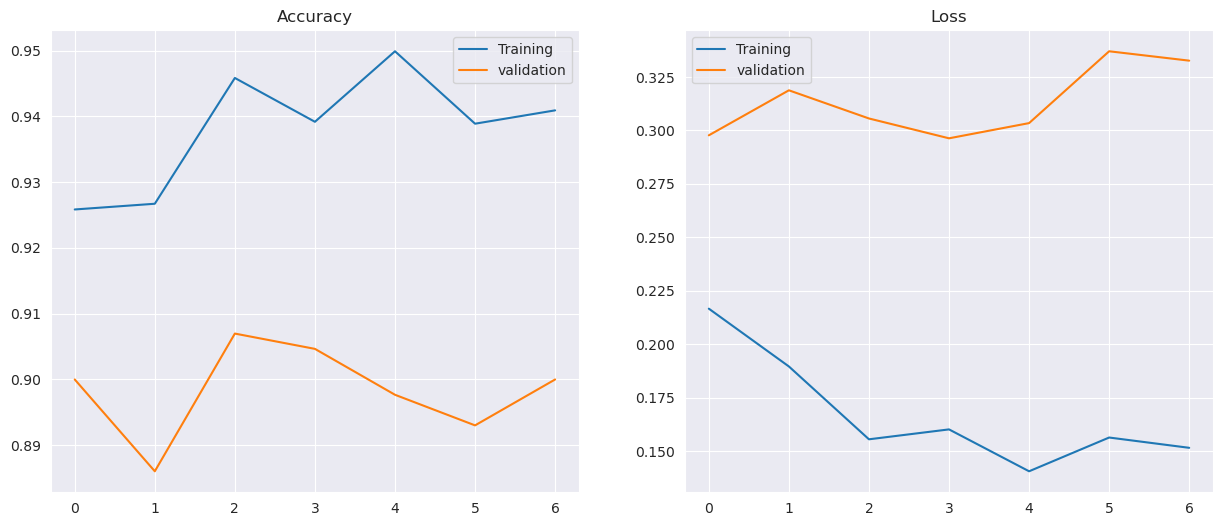

In [29]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(history1.epoch,history1.history['accuracy'],label = 'Training')
plt.plot(history1.epoch,history1.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history1.epoch,history1.history['loss'],label = 'Training')
plt.plot(history1.epoch,history1.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

In [30]:
preds1 = model1.predict(test_ds,verbose=1)

14/14 [==============================] - 6s 230ms/step


In [31]:
pred1 = [np.argmax(i) for i in preds1]
pred1[:5]

[1, 0, 0, 0, 0]

In [32]:
actual1 = test_ds.classes

In [33]:
print(classification_report(pred1,actual1))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        82
           1       0.94      0.93      0.94       107
           2       0.96      0.87      0.92        87
           3       0.92      0.97      0.94        70
           4       0.86      0.96      0.90        89

    accuracy                           0.92       435
   macro avg       0.92      0.92      0.92       435
weighted avg       0.92      0.92      0.92       435



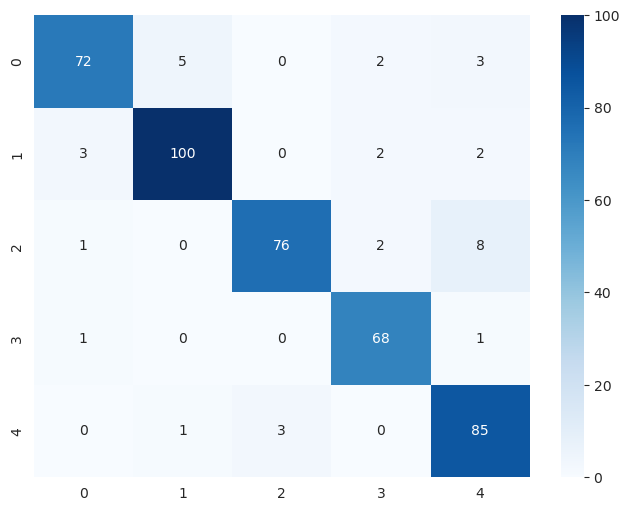

In [34]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred1,actual1),annot = True, fmt = 'd', cmap = 'Blues');